In [1]:
pip install torch pandas matplotlib seaborn scikit-learn


ar = 0.5 br = 0.8999999999999999


/tmp/ipython-input-383663735.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/data.csv', encoding='latin1')


GAN training finished


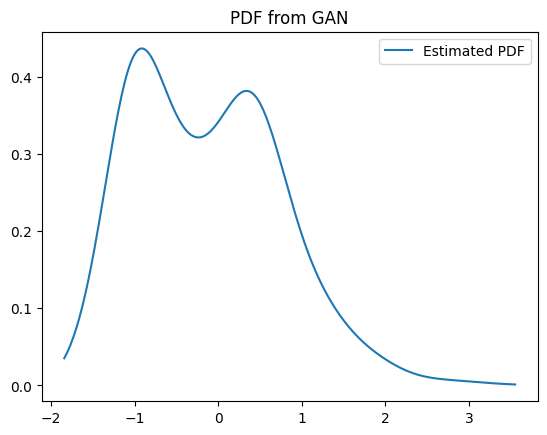

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# ===== roll number =====
r = 102303307
ar = 0.5 * (r % 7)
br = 0.3 * ((r % 5) + 1)

print("ar =", ar, "br =", br)

# ===== load data =====
df = pd.read_csv('/content/data.csv', encoding='latin1')
x = df["no2"].dropna().values

# ===== transform =====
z = x + ar * np.sin(br * x)
z = (z - np.mean(z)) / np.std(z)   # normalize

z = torch.tensor(z, dtype=torch.float32).view(-1,1)

# ===== generator =====
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
    def forward(self,x):
        return self.net(x)

# ===== discriminator =====
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

G = Generator()
D = Discriminator()

loss_fn = nn.BCELoss()
opt_g = torch.optim.Adam(G.parameters(), lr=0.001)
opt_d = torch.optim.Adam(D.parameters(), lr=0.001)

# ===== training =====
for epoch in range(3000):

    # real
    real = z[torch.randint(0,len(z),(64,))]
    real_labels = torch.ones((64,1))

    # fake
    noise = torch.randn(64,1)
    fake = G(noise)
    fake_labels = torch.zeros((64,1))

    # train discriminator
    d_loss = loss_fn(D(real), real_labels) + loss_fn(D(fake.detach()), fake_labels)
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    # train generator
    fake = G(noise)
    g_loss = loss_fn(D(fake), real_labels)
    opt_g.zero_grad()
    g_loss.backward()
    opt_g.step()

print("GAN training finished")

# ===== generate samples =====
noise = torch.randn(5000,1)
gen_samples = G(noise).detach().numpy()

# ===== KDE pdf =====
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(gen_samples)
x_vals = np.linspace(gen_samples.min(), gen_samples.max(), 300).reshape(-1,1)
pdf = np.exp(kde.score_samples(x_vals))

# ===== plot =====
plt.plot(x_vals, pdf, label="Estimated PDF")
plt.title("PDF from GAN")
plt.legend()
plt.show()
